In [3]:
import gmc_project
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import shutil
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')

def production_couche_vecteur_depl(paire_images, facteur_redimensionnement_pixels) :

    if paire_images.pa_status == 'complete' :

        #extraction matrice de disparités (dx,dy,corrélation ou non)
        disparity_initiale = paire_images.get_dispf_geoim() 
        magnitude_initiale = paire_images.get_magn_geoim()

        #redimensionnement geoim
        disparity = disparity_initiale.resize(facteur_redimensionnement_pixels, method = 'average')
        matrice_disparity = disparity.array

        magn = magnitude_initiale.resize(facteur_redimensionnement_pixels, method = 'average')
        matrice_magn = magn.array


        #extraction caract paire et formatage du nom de la couche de sortie
        x = paire_images

        #année de gauche de la paire
        yleft = x.pa_left.th_year

        #année de droite de la paire
        yright = x.pa_right.th_year

        nom_fichier = f'{x.pa_path}/vector_{yleft}-{yright}-{facteur_redimensionnement_pixels}.shp'

        #symbologie, pour que les différentes couches vectuers des différentes paires aient la même symbologie
        style_initial = '/home/gaiani/Documents/STAGE/mont-vallon/style_fleches.qml'
        copie = x.pa_path
        shutil.copy2(style_initial, copie)
        os.rename(f'{x.pa_path}/style_fleches.qml',f'{x.pa_path}/vector_{yleft}-{yright}-{facteur_redimensionnement_pixels}.qml')

        #extraction caractéristiques GeoIm
        (Ox,Oy) = disparity.getOrigin()  
        (Pix_X,Pix_Y) = disparity.getPixelSize()  
        (NombreBande,Nombreligne,Nombrecol) = disparity.getShape()  

        #création de deux matrices de coordonnés X et Y des pixels

        #coor x : nombre de colonnes à partir de Ox
        MatCoorX = np.arange(Ox,Ox + Pix_X*Nombrecol, Pix_X) 

        #coor y : nombre de lignes à partir de Oy
        MatCoorY = []
        MatCoorY.append([l for l in np.arange(Oy,Oy + Pix_Y*Nombreligne, Pix_Y)]) 

        #extraction valeurs des pixels
        data = [] 
        for numLigne,Ligne in enumerate(matrice_disparity[0]) :

            for numColon,Colon in enumerate(Ligne) :
                d = matrice_magn[numLigne][numColon]
                dx = matrice_disparity[0][numLigne][numColon]  
                dy = -matrice_disparity[1][numLigne][numColon]
                
                data.append([d,dx,dy,MatCoorX[numColon],MatCoorY[0][numLigne]])  

        #conversion en dataframe -> geodataframe -> couche vecteur, pixel avec valeur de magnitude, pas de vitesse
        dataf = pd.DataFrame(data)
        dataf.columns = ['d','dx', 'dy','CoorX','CoorY']  
        gdf = gpd.GeoDataFrame(dataf, geometry=gpd.points_from_xy(dataf.CoorX, dataf.CoorY), crs = {'init' : 'epsg:2154'})
        gdf.to_file(nom_fichier, driver = 'ESRI Shapefile')

---------
telenvi 5.0.3
---------
---------
GeoMultiCorr 0.0.0
---------


In [24]:
    # Création d'un objet de la classe GMC_Project, elle même écrite dans le script gmc_project qu'on a importé juste avant
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
import gmc_pair
paires_interessantes = etude.get_pairs()
for resize in [20] : 
        for index,paire_interet in enumerate(paires_interessantes) :
            production_couche_vecteur_depl(paires_interessantes[index],resize)

/home/gaiani/miniconda3/envs/gis_env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/gaiani/miniconda3/envs/gis_env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/gaiani/miniconda3/envs/gis_env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

In [ ]:
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
data = etude.get_pairs()
from telenvi import raster_tools as rt


def generation_raster(data):
#génère 3 fichiers v, vx et vy pour chaque paire d'images au statut complet dans data 
# (contient paires d'images d'un site donné)

    for pair_image in data :

        if pair_image.pa_status == 'complete' :

            target = pair_image.pa_dispf_path
            target_bis = pair_image.pa_magn_path
            yleft = pair_image.pa_left.th_year
            yright = pair_image.pa_right.th_year
            dossier_pair = pair_image.pa_path
            donnees_pair = pair_image.pa_key

            for elem in [1,2] : 

                bande_interet = rt.pre_process(target,nBands = elem, geoim = True)
                geoim_vitesse = bande_interet / abs(yright - yleft)

                if elem == 1 :
                    geoim_vitesse.save(f'{dossier_pair}/{donnees_pair}_vx.tif')

                else: 
                    geoim_vitesse.save(f'{dossier_pair}/{donnees_pair}_vy.tif')

            magn = rt.pre_process(target_bis, geoim = True)
            geoim_magn_vitesse = magn / abs(yright - yleft)
            geoim_magn_vitesse.save(f'{dossier_pair}/{donnees_pair}_v.tif')

generation_raster(data)

In [4]:
import gmc_project
import geopandas as gdp
from telenvi import raster_tools as rt
import numpy as np
import gmc_pair
import pandas as pd
import matplotlib.pyplot as plt
import gmc_geomorph
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')

from matplotlib import pyplot as plt
#plt.imshow(matrice)

etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')


def recup_zone_etude(statut_zone, index_zone):

    xz = etude._xzones

   # Selectionne les zones au statut x(stables, mouvantes...) dans le layer d'extraction
    statut = xz[xz.statut == str(statut_zone)]

    #recupere un polygone en particulier (index)
    xz_etudiee = statut.iloc[index_zone]

    return xz_etudiee

def visualisation(statut_zone) :
    xz = etude._xzones
    return(xz[xz.statut == str(statut_zone)])

def recup_nom_poly(statut_zone, index_zone):
    xz = etude._xzones
    statut = xz[xz.statut == str(statut_zone)]

    return(statut.iloc[index_zone].xz_id)

def mask_raster_depl_par_corr(paire,elem, statut_zone, index_zone) :

    z_cible = recup_zone_etude(statut_zone, index_zone)

    # Récupère la carte des correlations valides (1) et invalides (0) sous forme de GeoIm
    good_pixel_map = paire.get_disp_corr_geoim()

    # Récupère le raster de déplacemets de la paire
    # Ouvre le raster de déplacement v, vx ou vy de la paire
    if elem == 'v':
        disp_cible = paire.get_vmagn_geoim()
    elif elem == 'vx':
        disp_cible = paire.get_vx_geoim()
    elif elem == 'vy':
        disp_cible = paire.get_vy_geoim()

    disp_cible = disp_cible.cropFromVector(z_cible.geometry) #découpe selon l'emprise
    disp_cible.maskFromVector(z_cible.geometry)
    nbre_pixels_valides_1_masque = disp_cible.array.count()


    # Découpe le geoim de correlations sur l'emprise de la zone
    good_pixel_map = good_pixel_map.cropFromVector(z_cible.geometry)

    # Extrait la matrice de ce geoim
    ar_good_pixel_map = good_pixel_map.array

    # 3 lignes suivantes pour intervertir les 0 et les 1 sur l'ar_good_pixel_map
    # Et en faire masque utilisable dans une masked_array

    # Transforme les valeurs 0 en 999
    ar_good_pixel_map[ar_good_pixel_map==0] = 999

    # Transforme les 1 en 0
    ar_good_pixel_map[ar_good_pixel_map==1] = 0

    # Transforme les 999 en 1
    ar_good_pixel_map[ar_good_pixel_map==999] = 1

    # Utilisation de cette matrice binaire pour masquer le raster de déplacements
    disp_cible.array = np.ma.masked_array(
        data = disp_cible.array,
        mask = ar_good_pixel_map)
    
    nbre_pixels_valides_2_masques = disp_cible.array.count()

    
    #lignes suivantes pour filtrer les résultats
    #si plus de 50% du polygone est conservé, on garde 
    if nbre_pixels_valides_2_masques > 0.5 * nbre_pixels_valides_1_masque:
        return disp_cible
    

    #est alors masquée par le masque de corrélation et le maskFromVector (avoir valeurs sur z_etude)


def vitesse_par_zone(etude, year_debut, year_fin, statut_zone, index_zone) :
    
    """
    Toutes les données utiles sont récupérées depuis la variable passée dans l'argument 'etude'
    """
    data = etude.get_pairs_on_period(year_debut, year_fin)
    donnees_vitesses = []
    annees_paires = []
    nombre_paires_completes = 0
    for paire_interessante in data :
        don_vit = []

        #on parcourt les paires au statut valide, qu'on compte
        if paire_interessante.pa_status == 'complete':
            nombre_paires_completes += 1 

            #annees_paires contient la liste des duos d'années des paires
            annees_paires.append(f'{(paire_interessante.pa_left.th_date)[0:4]}-{(paire_interessante.pa_right.th_date)[0:4]}')

            debug = 0
            for elem in ['v', 'vx', 'vy'] :
                zone_interet = mask_raster_depl_par_corr(paire_interessante,elem, statut_zone, index_zone)
                
                if zone_interet is not None :

                #moyenne des valeurs de vitesse des pixels sur la zs
                    don_vit += [zone_interet.mean()]
                
                else :
                    debug = 1

            #debug devient 1 si zone_interet est un NoneType object : il faut supprimer la paire d'années ajoutée de la liste
            if debug  == 1 : 
                annees_paires.pop()

            #liste avec v, vx, vy pour chaque paire d'image
            donnees_vitesses += [don_vit] 
    
    #lignes suivantes pur supprimer sous-listes vides de données_vitesses
    x = []
    while x in donnees_vitesses:
        donnees_vitesses.remove(x)
    df = pd.DataFrame(donnees_vitesses,index = annees_paires, columns=['v','vx','vy'])
    df.index.name="Paire"
    return df

def df_vitesse_zS_to_csv(etude, year_debut, year_fin, index_zone) :

    df = vitesse_par_zone(etude, year_debut, year_fin, 'stable', index_zone)
    df.to_csv(f"dataframe_zS_{index_zone}.csv", sep = ',')

def tri_paires(etude,year_debut,year_fin,index_zone):

    "trie les paires d'images : supprime les paires qui ont une vitesse moyenne plus élevée en zone stable "
    "qu'en zone mouvante"

    #création d'un df qui contient v_z_mouv - v_z_stable
    vit_mouvement = vitesse_par_zone(etude,year_debut,year_fin,'mouvement',index_zone)
    vit_stable = vitesse_par_zone(etude,year_debut,year_fin,'stable',0) 
    dif_vit_periode = vit_mouvement - vit_stable 
    
    #suppression dans le df de difference de vitesses des paires où v_z_stable > v_z_mouv
    dif_vit_periode.drop(dif_vit_periode[(dif_vit_periode['v'] < 0)].index, inplace=True)

    #suppression des lignes avec valeur NaN (zone stable ou zone mouvante sans données donc différence ne marche pas)
    index_with_nan = dif_vit_periode.index[dif_vit_periode.isnull().any(axis=1)]
    dif_vit_periode.drop(index_with_nan,0, inplace=True)

    #on récupère les paires valides
    liste_paires_valides = dif_vit_periode.index.to_list()

    #on récupère les données de vitesse des paires valides dans le df initial
    vit_mouvement_valide = vit_mouvement.loc[liste_paires_valides]

    vit_mouvement_valide.to_csv(f"tri_paires_{recup_nom_poly('mouvement',index_zone)}.csv", sep = ',')


    return vit_mouvement_valide


In [75]:
recup_nom_poly('mouvement',1)
f"tri_paires_{str(recup_nom_poly('mouvement',0))}.csv"

'tri_paires_GRZ1_5.csv'

In [2]:
for i in range(0,7,1):
    tri_paires(etude,2001,2021,i)

ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/pr

IndexError: single positional indexer is out-of-bounds

In [3]:
visualisation('mouvement')

    xz_id  xz_pz_name     statut  \
1  GRZ1_5         NaN  mouvement   
2  GRZ1_6         NaN  mouvement   
3  GRZ2_1         NaN  mouvement   
4  GRZ2_2         NaN  mouvement   
5  GRZ2_3         NaN  mouvement   
6  GRZ3_1         NaN  mouvement   

                                            geometry  
1  POLYGON ((981924.307 6476655.074, 981947.198 6...  
2  POLYGON ((981881.794 6476689.084, 981912.534 6...  
3  POLYGON ((982226.056 6476739.123, 982228.905 6...  
4  POLYGON ((982169.007 6476838.601, 982172.852 6...  
5  POLYGON ((982159.379 6476937.225, 982162.614 6...  
6  POLYGON ((982260.478 6476516.110, 982262.294 6...  


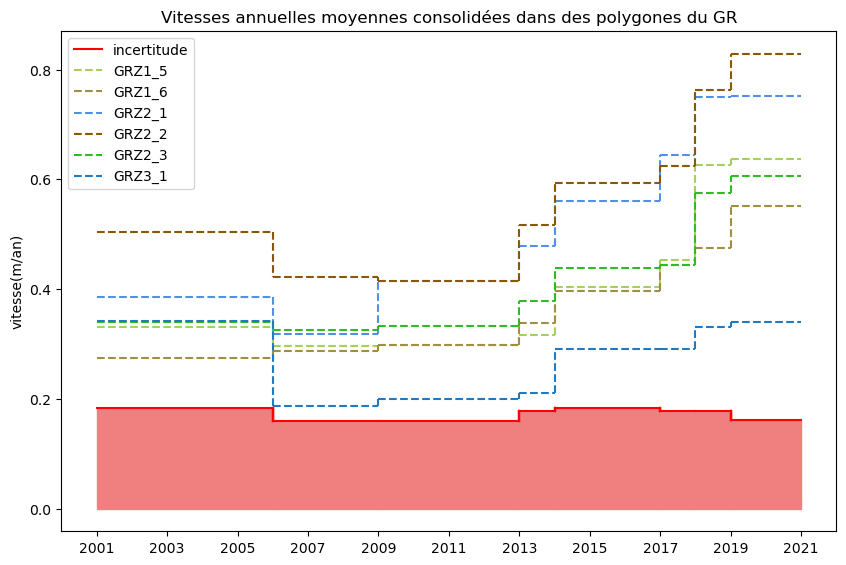

In [11]:
# le csv est issu de la fonction tri_paires pour la période 2001-2021

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def lecture_csv(chemin_csv) :
    return pd.read_csv(chemin_csv)

def periodes_etude(chemin_csv) : 

    lire = lecture_csv(chemin_csv)
    Liste_annees = []
    Liste_periode_virgule = []

    for annees in lire['Paire']:

        #Liste_annees contient la liste des années présentes dans le dataframe issu de tri_paires
        if annees[0 : 4] not in Liste_annees:
            Liste_annees.append(annees[0 : 4])
        if annees[0 : 4] not in Liste_annees:
            Liste_annees.append(annees[0 : 4])
    
    for annees in lire['Paire']:

        #Liste_annees contient la liste des années présentes dans le dataframe issu de tri_paires
        if annees[5 : 9] not in Liste_annees:
            Liste_annees.append(annees[5 : 9])
        if annees[5 : 9] not in Liste_annees:
            Liste_annees.append(annees[5 : 9])

    #transforme chaque année (str) en entier
    Liste_annees_ordonnees = [int(annee) for annee in Liste_annees]

    #classe la liste dans l'ordre croissant
    Liste_annees_ordonnees.sort()


    #b : liste des années de la première à l'avant dernière position de Liste_annees_ordonnees
    b = Liste_annees_ordonnees[0:len(Liste_annees_ordonnees)-1]

    #c : liste des années de la deuxième à la dernière position de Liste_annees_ordonnees
    c = Liste_annees_ordonnees[1:len(Liste_annees_ordonnees)]

    for index, year_left in enumerate(b) :

        Liste_periode_virgule.append([year_left, c[index]])

    #liste des périodes entre les années min et max du csv, séparation des années par des virgules
    return Liste_periode_virgule

def periodes_etude_separateur_tiret(Liste_periodes_virgule):
    
    Liste_periodes__tirets = []    
    for  index,periode in enumerate(Liste_periodes_virgule):

            #stockage sous forme différente avec tirets comme séparateurs
            Liste_periodes__tirets.append(f"{Liste_periodes_virgule[index][0]}-{Liste_periodes_virgule[index][1]}")

    #liste des périodes entre les années min et max du csv, séparation des années par des tirets
    return Liste_periodes__tirets


def selection_paire_avt_tri_med(chemin_csv,binf,bsup) :
    lire = lecture_csv(chemin_csv)

    #liste de toutes les années entre les 2 bornes de la période étudiée
    ye = np.arange(float(binf),float(bsup) + 1, 1)
    L = []
    for paire in lire['Paire'] :
        # Bornes de la paire
        yminp = min(int(paire[0:4]),int(paire[5:9]))
        ymaxp = max(int(paire[0:4]),int(paire[5:9]))

        # Déroule toutes les années entre les bornes de la paire
        yp = np.arange(yminp, ymaxp+1, 1)

        # Détermine si une paire est intéressante au regard de la période d'étude
        y_common = np.intersect1d(yp, ye)

        #sélection des paires avec au moins 2 années en commun, sinon sélectionne aussi 
        # les paires ayant juste en commun la borne sup de la période d'étude
        if len(y_common) > 1: 
            L.append(paire)
    return L

def tri_paires_par_ecart_med(chemin_csv,binf,bsup, seuil_med) :

    "trie paire par écart à la médiane, et sort une vitesse moyenne pour le polygone et la période étudiés"

    #entrée : paires incluses dans la période étudiée; sortie : moyenne des vitesses des paires non éliminées par écart à la médiane
    lire = lecture_csv(chemin_csv)

    #on sélectionne les paires d'années intéressantes
    paires_interessantes = selection_paire_avt_tri_med(chemin_csv, binf, bsup)
    if len(paires_interessantes) != 0 :
        liste_vit = []

        for paire in paires_interessantes:

            #on stocke la valeur de vitesse associée à chaque paire d'années 
            liste_vit.append(lire[lire['Paire'] == str(paire)]['v'])

        #on dét la médiane des vitesses des paires étudiées
        med = np.median(liste_vit)
        liste_vit_valides = []

        for paire in paires_interessantes:

            vit = float(lire[lire['Paire'] == str(paire)]['v'])

            #on conserve une valeur v si elle est inclue dans un certain écart à la médiane
            if (1 - seuil_med) * med <= vit <= (1 + seuil_med) * med :
                liste_vit_valides.append(vit)

        #on fait la moyenne des valeurs de vitesse restantes : vitesse moyenne de deplacement sur
        #  le polygone et la période étudiés
        return np.mean(liste_vit_valides)
    else :
        return None

def donnees_vitesse_finales_zM(chemin_csv, seuil_med):

    liste_periodes = periodes_etude(chemin_csv)
    donnees_vitesses = []
    liste_periodes_bis = periodes_etude_separateur_tiret(liste_periodes)

    #on parcourt la liste d'années
    for  periode in liste_periodes:

            #v_moyenne sur période donnée en éliminant mauvaises paires avec écart à med donné
            v_moyenne = tri_paires_par_ecart_med(chemin_csv,periode[0],periode[1],seuil_med)
            if type(v_moyenne) == None :
                donnees_vitesses.append(None)
            else : 
                donnees_vitesses.append(v_moyenne)

    #df avec vitesse moyenne sur polygone de zone mouvante sur toutes les périodes
    df = pd.DataFrame(donnees_vitesses,index = liste_periodes_bis, columns=['v_moy'])
    df.index.name="Periode"

    return df
    
def donnees_vitesse_finales_zS(chemin_csv):
        #chemin_csv associé au df de la vitesse par paire en zone stable
        
        liste_periodes = periodes_etude(chemin_csv)
        donnees_vitesses= []

        #futur index du dataframe
        liste_periodes_bis = periodes_etude_separateur_tiret(liste_periodes)
        donnees_vitesses_medianes = []


    #chemin_csv le csv de vitesses en zone stable, qui n'a pas subi le traitement de tri par différence entre zones de mouvement et zone stable
        lire = lecture_csv(chemin_csv)


        for  periode in liste_periodes:

            #sélection des paires avec période incluse dans periode
            paires_interessantes = selection_paire_avt_tri_med(chemin_csv, periode[0], periode[1])

            if len(paires_interessantes) != 0 :
                for paire in paires_interessantes:

                #on stocke la valeur de vitesse associée à chaque paire d'années 
                    donnees_vitesses.append(lire[lire['Paire'] == str(paire)]['v'])

            #contient médiane des vitesses des paires valides sur la période étudiée
            donnees_vitesses_medianes.append(np.median(donnees_vitesses))

        #contient vitesses médiane en zs par période
        df = pd.DataFrame(donnees_vitesses_medianes, index = liste_periodes_bis, columns=['v_moy'])
        df.index.name="Periode"
        
        return df  

def taux_d_acceleration(chemin_csv,seuil_med):

    df = donnees_vitesse_finales_zM(chemin_csv,seuil_med)

    #contiendra les taux d'accel associés à chaque période
    taux_accel = []

    #v_ini correspond à la vitesse initiale, ici 2001-2006
    v_ini = df['v_moy'][0]

    periodes = periodes_etude(chemin_csv)
    periodes_tiret = periodes_etude_separateur_tiret(periodes)

    (ligne,colonne) = df.shape

    for index in range(ligne):

        #tx le taux d'accel : (vf-vi)/vi * 100 pour avoir un pourcentage
        tx = int(((df['v_moy'][index] - v_ini) / v_ini) * 100)

        taux_accel.append(tx)

    #df avec le tx d'accel en fonction des périodes
    df_sortie = pd.DataFrame(data = taux_accel, index = periodes_tiret, columns = ['taux_acceleration (%)'])
    df_sortie.index_name = 'Periode'
    return df_sortie


def formatation_donnees_serieT(chemin_csv_m,chemin_csv_s,seuil_med) :

    df_m = donnees_vitesse_finales_zM(chemin_csv_m,seuil_med)
    df_s = donnees_vitesse_finales_zS(chemin_csv_s)
    (ligne,colonne) = df_m.shape
    vm = [df_m.v_moy[period] for period in range(ligne)]
    vs = [df_s.v_moy[period] for period in range(ligne)]
    period = periodes_etude(chemin_csv_m)
    disps = pd.DataFrame({'period' : period, 'vm' : vm, 'vs' : vs}, columns = ['period','vs','vm'])
    return disps

def generation_color(dispsc):

    #génère x tupples de 3 réels aléatoires permettant d'obtenir x couleurs différentes
    l = []
    for i in range(0, len(dispsc)):
        l.append(tuple(np.random.choice(range(0,256), size=3)/255))
    return l

def draw_time_series(dispsmultiples, bounds=None, savepath=None):

    # Create plot figure
    fig, ax = plt.subplots(figsize=(10,6.5))

    colour = generation_color(dispsmultiples)

    liste_legende = [recup_nom_poly('mouvement',index) for index in range(0,6)]
    
    nombre_zone = 0
    for disps in dispsmultiples :

        color = colour[nombre_zone]
        periode = 0
        for period in disps.iloc:
            
            # Recupere les bornes de la periode d'etude
        
            ya = period.period[0]
            yb = period.period[1]

            # Récupère les valeurs de déplacements pour zone mouvante et stable
            mean_velocity = period.vm
            uncertainity = period.vs

            #donnees pour tracer barres verticales du graph
            c = disps.iloc[periode-1][2] #valeur de vitesse de la borne sup de la période précédente
            d = disps.iloc[periode-1][1] #valeur d'incertitude de la borne sup de la période précédente

            # Affiche l'incertitude : que pour premier polygone : identique pour tous les polygones de zM (même zS)

            #première période : on inclue le label pour que la légende ne s'affiche qu'une fois, lignes horizontales
            if (periode == 0) & (nombre_zone == 0):
                ax.plot([int(ya), int(yb)],[uncertainity, uncertainity], label = 'incertitude', color='red')
                plt.fill_between([ya,yb],[uncertainity,uncertainity], color = 'lightcoral')
                
            #périodes suivantes 
            elif (periode != 0) & (nombre_zone == 0): 
                ax.plot([int(ya), int(yb)],[uncertainity, uncertainity], color='red')
                plt.fill_between([ya,yb],[uncertainity,uncertainity], color = 'lightcoral')


            #lignes verticales
            if (periode != 0 & nombre_zone == 0):
                ax.plot([int(ya),int(ya)],[d,uncertainity], color = 'red')

            # Trace la serie temporelle (lignes horizontales)

            #première période : légende inclue, pour qu'elle ne soit affichée qu'une fois
            if periode == 0 :
                ax.plot([int(ya), int(yb)],[mean_velocity, mean_velocity], label = liste_legende[nombre_zone], linestyle ='--',color=color,)

            else : 
                 ax.plot([int(ya), int(yb)],[mean_velocity, mean_velocity], linestyle ='--',color=color,)

            #lignes verticales
            if periode != 0:
                ax.plot([int(ya),int(ya)],[c,mean_velocity],linestyle ='--', color = color)

            periode += 1

        nombre_zone += 1
      
    plt.legend(loc = 'best')

    # Verrouille les bornes inférieure et supérieure de l'axe Y du graphe
    if bounds != None:
        ax.set_ybound(lower=bounds[0], upper=bounds[1])

    # Verrouille les bornes des périodes à afficher
    ax.set_xticks(np.arange(2001,2023,2))

    # Titre le graphe
    ax.set_title(f"Vitesses annuelles moyennes consolidées dans des polygones du GR")

    # Sauve si demandé
    if savepath != None:
        fig.savefig(savepath)
    plt.ylabel('vitesse(m/an)')

#on définit dispsmultiples (contient les df de vitesse par période de plusieurs polygone de GR) et liste_poly
dispsmultiples = []
liste_poly = [recup_nom_poly('mouvement',index) for index in range(0,6)]

for elem in liste_poly :
    a = formatation_donnees_serieT(f"/home/gaiani/Documents/STAGE/GeoMultiCorr/src/tri_paires_{elem}.csv",'/home/gaiani/Documents/STAGE/GeoMultiCorr/src/dataframe_zS_0.csv',0.8)
    dispsmultiples.append(a)

draw_time_series(dispsmultiples)

In [4]:
def visualisation_graphique(df) :
    
    # visualisation résultats en nuage de points
    low,max = -2.5, 2.5
    fig, axs = plt.subplots(1,3)
    x_std = [1 for x in range(len(df))]
    gv, gvx, gvy = axs
    axs = [gv, gvx, gvy]
    color = ['blue','red','orange']
    titre = ['V','VX','VY']
    i = 0
    for elem in [df.v,df.vx,df.vy] :
        axs[i].scatter(x_std, elem, c=color[i], s=100, alpha=0.5, marker='+')
        axs[i].set_title(titre[i])
        axs[i].set_ybound((low,max))
        i += 1 

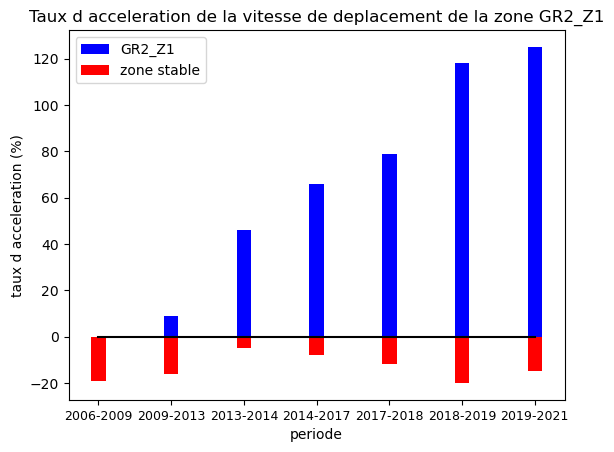

In [37]:
chemin_zM = '/home/gaiani/Documents/STAGE/GeoMultiCorr/src/tri_paires_GRZ2_1.csv'
chemin_zS = '/home/gaiani/Documents/STAGE/GeoMultiCorr/src/dataframe_zS_0.csv'
seuil_med = 0.5
import matplotlib.pyplot as plt


def draw_taux_accel(chemin_zM, chemin_zS, seuil_med):

    #df de tx d'accel en zones mouvante et stable
    df_zM = taux_d_acceleration(str(chemin_zM),seuil_med)
    df_zS =  taux_d_acceleration(str(chemin_zS),seuil_med)
    period = periodes_etude(str(chemin_zM))

    #liste de tx d'accel en zS et zM, liste de périodes
    tx_zM = []
    tx_zS = []
 
    for ligne in df_zM.iloc :
        tx_zM.append(ligne[0])
    tx_accel_zM = tx_zM[1:]

    for ligne in df_zS.iloc :
        tx_zS.append(ligne[0])
    tx_accel_zS = tx_zS[1:]

    abs = [f"{period[i][0]}-{period[i][1]}" for i in range(len(period))]
    A = abs[1:]

    #zM
    plt.bar(A,tx_accel_zM, color = 'blue', width=0.2, label = 'GR2_Z1')
    #zS
    plt.bar(A,tx_accel_zS, color = 'red', width=0.2, label = 'zone stable')
    plt.plot(A,[0 for x in range(len(A))], color = 'black')
    plt.legend()

    plt.xlabel('periode')
    plt.ylabel('taux d acceleration (%)')
    plt.title('Taux d acceleration de la vitesse de deplacement de la zone GR2_Z1')
    plt.tick_params(axis = 'x', labelsize = 9)

draw_taux_accel(chemin_zM, chemin_zS, seuil_med)

In [31]:
period

[[2001, 2006],
 [2006, 2009],
 [2009, 2013],
 [2013, 2014],
 [2014, 2017],
 [2017, 2018],
 [2018, 2019],
 [2019, 2021]]

In [1]:
taux_d_acceleration('/home/gaiani/Documents/STAGE/GeoMultiCorr/src/dataframe_tri_paires_1.csv')
import matplotlib.pyplot as plt

def draw_taux_accel(chemin_csv, color='black', bounds=None, savepath=None):

    period = periodes_etude(chemin_csv)
    df = taux_d_acceleration(chemin_csv)
    
    # Create plot figure
    fig, ax = plt.subplots(figsize=(10,6.5))
    
    i = 0
    for ligne in df.iloc:
        ya = period[i][0]
        yb = period[i][1]

        # Récupère les valeurs de déplacements pour zone mouvante et stable
        tx_accel = df['taux_acceleration (%)']

        # Trace la serie temporelle
        ax.plot([int(ya), int(yb)],[tx_accel, tx_accel], color=color)
        ax.plot([int(ya), int(yb)],[tx_accel, tx_accel], 'bo', linewidth=0.5, color=color)

        # Verrouille les bornes inférieure et supérieure de l'axe Y du graphe
        if bounds != None:
            ax.set_ybound(lower=bounds[0], upper=bounds[1])

        # Verrouille les bornes des périodes à afficher
        ax.set_xticks(np.arange(2001,2023,2))
        i += 1

draw_taux_accel('/home/gaiani/Documents/STAGE/GeoMultiCorr/src/dataframe_tri_paires_1.csv')

NameError: name 'taux_d_acceleration' is not defined

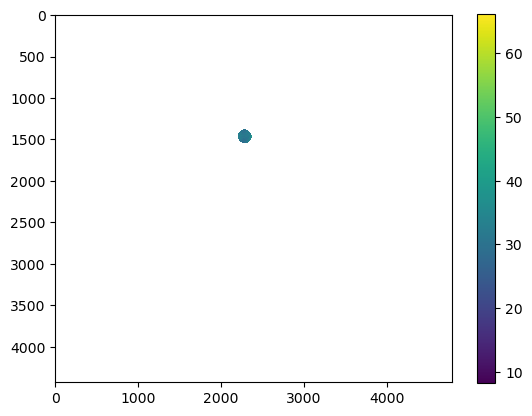

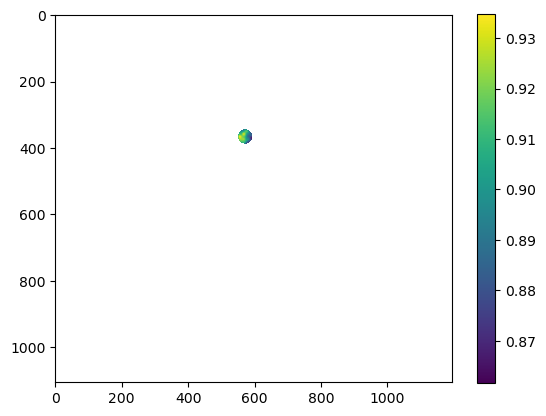

In [101]:
chemin_raster_bis = "/home/gaiani/Documents/STAGE/mont-vallon/pente_mont_vallon.tif"
poly = recup_zone_etude('mouvement',0)

pente = rt.pre_process(chemin_raster_bis, geoim = True)
pente.maskFromVector(poly.geometry)
p_bis = pente.array

paire = etude.get_pairs(['2014','2018'])[0]
a = paire.get_vmagn_geoim()
a.maskFromVector(poly.geometry)
a.show() 

